In [0]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sb

import datetime

import re
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
import konlpy
import nltk

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import TruncatedSVD


### load data

In [0]:
# load pickle
with open('data/rawdata_문재인.pickle','rb') as f:
    obj_json = pickle.load(f)

In [0]:
obj_json.keys()

dict_keys(['result', 'return_object'])

### check attributes

In [0]:
# docs 
list_docs = obj_json['return_object']['documents']
n_docs = len(list_docs)
print(n_docs)

5000


In [0]:
# 기사 속성 확인
doc0 = list_docs[0]
for att in doc0.keys():print(att)

news_id
title
content
hilight
published_at
enveloped_at
dateline
provider
category
category_incident
provider_subject


In [0]:
type(doc0['content'])

str

### json obj to csv

In [0]:
# news_id, dateline, category, title, content, provider
dict_news  = {'news_id':[],'dateline' : [], 'category' : [], 'title' : [], 'content':[], 'provider': [] }
for doc in list_docs:
    dict_news['news_id'].append(doc['news_id'])
    dict_news['dateline'].append(doc['dateline'])
    dict_news['category'].append(doc['category'])
    dict_news['title'].append(doc['title'])
    dict_news['content'].append(doc['content'])
    dict_news['provider'].append(doc['provider'])

In [0]:
for key in dict_news.keys():
    print(f'{key} : {len(dict_news[key])}')

news_id : 5000
dateline : 5000
category : 5000
title : 5000
content : 5000
provider : 5000


In [0]:
df_news = pd.DataFrame.from_dict(dict_news)

In [0]:
df_news['content'].apply(type)

0       <class 'str'>
1       <class 'str'>
2       <class 'str'>
3       <class 'str'>
4       <class 'str'>
5       <class 'str'>
6       <class 'str'>
7       <class 'str'>
8       <class 'str'>
9       <class 'str'>
10      <class 'str'>
11      <class 'str'>
12      <class 'str'>
13      <class 'str'>
14      <class 'str'>
15      <class 'str'>
16      <class 'str'>
17      <class 'str'>
18      <class 'str'>
19      <class 'str'>
20      <class 'str'>
21      <class 'str'>
22      <class 'str'>
23      <class 'str'>
24      <class 'str'>
25      <class 'str'>
26      <class 'str'>
27      <class 'str'>
28      <class 'str'>
29      <class 'str'>
            ...      
4970    <class 'str'>
4971    <class 'str'>
4972    <class 'str'>
4973    <class 'str'>
4974    <class 'str'>
4975    <class 'str'>
4976    <class 'str'>
4977    <class 'str'>
4978    <class 'str'>
4979    <class 'str'>
4980    <class 'str'>
4981    <class 'str'>
4982    <class 'str'>
4983    <class 'str'>
4984    <c

### category

카테고리는 대분류>소분류 형태  
level = 2, not exclusive class

* 문재인 관련 기사 대분류
    * 정치>
        * 북한, 선거, 외교, 국회_정당, 행정 _ 자치, 청와대, 정치일반
    * 사회>
        * 날씨, 여성, 환경, 교육_시험, 사건 _ 사고, 의료_건강, 미디어, 장애인, 사회일반
    * 국제>
        * 일본,중국,미국 _ 북미, 중동 _ 아프리카, 러시아, 아시아, 중남미, 유럽 _ EU, 국제일반
    * 경제>
    * 문화>
    * 지역>
    * IT_과학>
    * 스포츠>

In [0]:
# get category
list_cat = []
for i in range(n_docs):
    list_cat.append(list_docs[i]['category'])
ser_cat = pd.Series(list_cat)

In [0]:
# 리스트로 들어있다.
ser_cat[0]

['사회>사건_사고']

In [0]:
# category list 길이 확인
# 3,2,1,0
n_cat = ser_cat.apply(len)
n_cat.value_counts()

3    2093
2    1351
1    1279
0     277
dtype: int64

#### 대분류 탐색

In [0]:
main_cat = []
for cat in ser_cat:
    for cat_el in cat:
        main_cat.append(cat_el.split('>')[0] if len(cat)>0 else None)
main_cat = pd.Series(main_cat)

In [0]:
main_cat.value_counts()

정치       7431
사회       1015
국제        720
경제        564
문화        270
지역        187
IT_과학      70
스포츠         3
dtype: int64

### category_incident
대부분이 0 이다
못쓰겠다 ㅅㅂ

In [0]:
list_cat_inc = []
for doc in list_docs:
    list_cat_inc.append(doc['category_incident'])
ser_cat_inc = pd.Series(list_cat_inc)

In [0]:
len_cat_inc = ser_cat_inc.apply(len)
len_cat_inc.value_counts()

0    4241
1     598
2     116
3      31
4      10
5       3
6       1
dtype: int64

In [0]:
cat_inc_1 = ser_cat_inc[len_cat_inc == 1]
cat_inc_1[:10]

0        [범죄>범죄일반>방화]
3        [범죄>범죄일반>방화]
5        [사고>산업사고>화재]
8        [사고>산업사고>화재]
23    [범죄>기업범죄>내부자거래]
25    [사고>산업사고>원자력사고]
28       [사고>산업사고>화재]
35       [범죄>범죄일반>방화]
36     [범죄>기업범죄>거래제한]
37       [사고>산업사고>화재]
dtype: object

#### 정치>북한 에 대한 기사 시계열
dateline : year-month-day
year, month, day, hour 로 분리

In [0]:
datetime.datetime.strptime('2019-04-18','%Y-%m-%d').day

18

In [0]:
df_news['dateline'][0]

'2019-04-18T05:04:53.000+09:00'

In [0]:
# year, month, day,hour로 분리
df_news['date'] = df_news['dateline'].apply(lambda dateline : datetime.datetime.strptime(dateline[:10].strip(),'%Y-%m-%d'))

df_news['year'] = df_news['date'].apply(lambda date : date.year)
df_news['month'] = df_news['date'].apply(lambda date : date.month)
df_news['day'] = df_news['date'].apply(lambda date : date.day)
df_news['hour'] = df_news['dateline'].apply(lambda dateline : int(dateline.split('T')[1][:2].strip()))

In [0]:
# 카테고리에 '정치>북한' 이 포함된 기사 추출
is_pol_nk = df_news['category'].apply(lambda x : True if '정치>북한'in x else False)
df_pol_nk = df_news[is_pol_nk]

In [0]:
# 795개
df_pol_nk.shape

(795, 11)

In [0]:
print(f"min : {df_pol_nk['date'].min()}, max : {df_pol_nk['date'].max()}")

min : 2019-03-24 00:00:00, max : 2019-04-17 00:00:00


In [0]:
cnt_news = df_pol_nk.groupby('date')['news_id'].count().reset_index()
cnt_news.columns

Index(['date', 'news_id'], dtype='object')

In [0]:
cnt_news['date'].values

array(['2019-03-24T00:00:00.000000000', '2019-03-25T00:00:00.000000000',
       '2019-03-26T00:00:00.000000000', '2019-03-27T00:00:00.000000000',
       '2019-03-28T00:00:00.000000000', '2019-03-29T00:00:00.000000000',
       '2019-03-30T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
       '2019-04-01T00:00:00.000000000', '2019-04-02T00:00:00.000000000',
       '2019-04-03T00:00:00.000000000', '2019-04-04T00:00:00.000000000',
       '2019-04-05T00:00:00.000000000', '2019-04-06T00:00:00.000000000',
       '2019-04-07T00:00:00.000000000', '2019-04-08T00:00:00.000000000',
       '2019-04-09T00:00:00.000000000', '2019-04-10T00:00:00.000000000',
       '2019-04-11T00:00:00.000000000', '2019-04-12T00:00:00.000000000',
       '2019-04-13T00:00:00.000000000', '2019-04-14T00:00:00.000000000',
       '2019-04-15T00:00:00.000000000', '2019-04-16T00:00:00.000000000',
       '2019-04-17T00:00:00.000000000'], dtype='datetime64[ns]')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


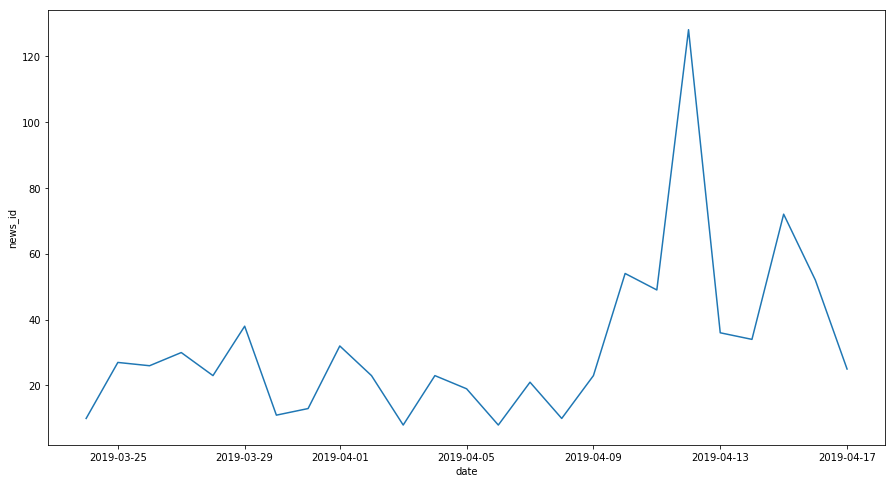

In [0]:
# 날짜별 기사 수 분포
plt.figure(figsize = (15,8))
sb.lineplot(x='date',y='news_id',data = cnt_news)
plt.show()

### 본문 분석

In [0]:
reg_sc = re.compile("\n+|·|ㆍ|…|◆+|◇+|▶+|●+|▲+|\\\\|“|”|‘|’")
reg_reporter = re.compile('[가-힣]+\s[가-힣]*기자')
reg_email = re.compile('[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$')
reg_date = re.compile('\d*일|\d*월|\d*년|\(현지시간\)|\(현지시각\)')

In [0]:
docs_nk = df_pol_nk['content']

In [0]:
# 전처리
docs_pp = []
for doc in docs_nk:
    tmp = re.sub(reg_sc,'',doc)
    tmp = re.sub(reg_reporter,'',tmp)
    tmp = re.sub(reg_email,'',tmp)ha
    tmp = re.sub(reg_date,'',tmp)

  docs_pp.append(tmp.strip('\'"'))

In [0]:
print(docs_pp[9])

北비핵화 의지 확인한 후 3차 미북 정상회담 추진해야"  두 차례의 미북 정상회담 이후 미 의회 의원들 사이에서 '톱다운'(Top-Down) 방식의 비핵화 협상에 대한 회의론이 커지고 있다고 미국의 소리(VOA)가  전했다. 톱다운 방식이란 정상 간 먼저 합의한 뒤 실무협상을 진행하는 방식을 말한다. 문재인 대통령은 지난  도널드 트럼프 미 대통령과 정상회담에서 미북 간 톱다운 방식으로 성과를 확보해야 한다고 했다.  VOA에 따르면 미 상원 외교위 소속 민주당 크리스 쿤스 의원은 하노이 회담 결렬 이후 "정상급 대화는 사전 준비와 이해가 선결되고 긍정적인 방향으로 가고 있음을 보여주는 토대가 마련됐을 때만 목적 의식이 있는 것"이라고 밝혔다. 북한의 비핵화 의지를 실무 협상을 통해 확인한 뒤 3차 미북 정상회담을 추진해야 한다는 뜻으로 해석된다.  외교위 산하 동아시아태평양소위원장인 공화당 소속 코리 가드너 상원의원도 "미국이 해야 할 은 미국의 최대 압박 정책을 완전히 시행하는 것"이라며 "정상회담 전후로, 완전하고 검증 가능하며 돌이킬 수 없는 비핵화를 향한 구체적 조치 없이 북한 정권에 대한 압박이 약화돼 우려된다"고 했다.  VOA는 특히 하노이 회담 종료 이후 미 의회 내에서 이같은 기류가 형성되고 있다고 전했다. 대북 금융 제재 강화 법안인 브링크액트(BRINK Act)가 2차 미북 정상회담 합의 무산 이후 만에 재상정된 것이 대표적인 예라는 것이다.  또 VOA는 기존과 달리 민주당에서 추가 대북 제재의 필요성을 강경하게 주장하고 있다는 점도 주목할 만하다고 전했다. 척 슈머 상원 민주당 원내대표는 최근 이 매체에 "제재가 깊고 강력하며 오래 지속되지 않는 한 김정은 북한 국무위원장은 핵 무기를 포기하지 않을 것"이라며 제재 강화의 필요성을 피력한 것으로 알려졌다.  VOA는 북한의 비핵화 협상의 목표 수정 가능성을 열어둬야 한다는 지적도 중진 의원들을 통해 나오고 있다고 전했다. 상원 외교위 민주당 간사인 밥 메넨데즈 의원은 "김정은은 모든 핵

In [0]:
for doc in docs_pp[:10]:
    print(doc)

북, 유해 공동발굴철도도로 공동조사 등 소극적 태도 관 안보리 만대 공동발굴 추가 제재 면제 결정에도 불투명유엔 안전보장이사회가  고려시대 궁궐터인 개성 만대의 공동발굴에 필요한 장비와 기계류의 북한 반출 제재를 면제하기로 결정했다. 부터 중단과 재개를 반복해온 만대 공동발굴은 남북 역사문화 협력의 상징적 사업이다. 그러나 하노이 회담 결렬로 북미 대화가 교착 상태에 빠진 이후 북한이 남북 간 현안 논의에 소극적인 태도를 취하는 탓에 발굴 사업 재개까지 시이 걸릴 것으로 보인다. 정부는 제재의 틀 내에서 가능한 남북 교류협력을 확대할 방침이다. 하지만 북측이 평양공동선언에서 합의했거나 민감하지 않은 남북협력 사업까지 무대응으로 관하고 있어 추진 동력이 약화되고 있다. 이미 유엔 안보리 제재 면제가 완료된 유해 공동발굴, 철도도로 공동조사 및 연결, 이산가족 화상상봉 등도 북측과의 논의가 진척되지 않아 겉돌고 있는 실정이다. 복수의 외교소식통은  남북 간 협의할 사안이 많은데 의견을 물어도 북측에서 회신이 없는 것으로 안다고 말했다. 남북 협력사업을 위한 제재 면제를 논의하는 한미 워킹그룹은 순서상 서울에서 대면회의를 열어야 하지만 개최 정이 불투명한 상태다. 이산가족 화상상봉을 논의할 남북 적십자회담도 답보 상태다. 남북 간 24시간 연락 창구를 표방하는 개성 남북공동연락사무소의 운영도 원활하지 않은 것으로 전해졌다. 매주 금요 열기로 한 소장 회의는 지난 을 마지막으로 소식이 없다. 개성 연락사무소가 지난달 북측이 방적으로 철수했다 복귀하는 해프닝을 겪은 이후 사실상 개점 휴업 상태라는 관측이 나오는 배경이다.  유니세프와 세계식량계획(WFP)에 공여하기로 의결한 대북 인도적 지원 명목의 800만달러 집행을 논의할 남북교류협력추진위원회도 정을 잡지 못하고 있다.이 때문에 남북관계로 북미관계를 견인한다는 문재인 정부의 구상도 차질이 불가피해졌다는 분석이 나온다. 비핵화 협상 구조상 북미관계가 경색되면 남북관계는 후순위로 밀리게 된다. 북미 대화가 원활해야 남북

In [0]:
# 문서 길이 분포 확인
len_docs = []
for doc in docs_pp:
    len_docs.append(len(doc))
len_docs = pd.Series(len_docs)

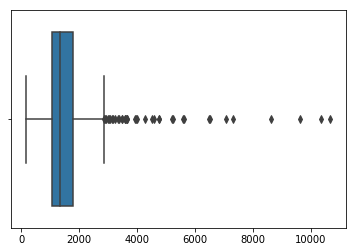

In [0]:
sb.boxplot(len_docs)
plt.show()

In [0]:
len_docs.describe()

count      795.000000
mean      1534.309434
std        985.315149
min        155.000000
25%       1046.000000
50%       1339.000000
75%       1769.500000
max      10679.000000
dtype: float64

### tfidf

**단어만 추출**

In [0]:
s = '문재인이 개 미친 강한 핵을 발사했다'

In [0]:
hn.analyze(s)

[[[('문재', 'ncn'), ('인', 'ncn'), ('이', 'jcc')],
  [('문재', 'ncn'), ('인', 'ncn'), ('이', 'jcs')]],
 [[('개', 'nbu')],
  [('개', 'ncn')],
  [('개', 'pvg'), ('어', 'ecs')],
  [('개', 'pvg'), ('어', 'ecx')],
  [('개', 'pvg'), ('어', 'ef')]],
 [[('미치', 'pvg'), ('ㄴ', 'etm')]],
 [[('강하', 'paa'), ('ㄴ', 'etm')]],
 [[('핵', 'ncn'), ('을', 'jco')]],
 [[('발사', 'ncpa'), ('하', 'xsva'), ('었', 'ep'), ('다', 'ef')]]]

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf

In [0]:
from konlpy.tag import Hannanum
hn = Hannanum()
#analyze, morphs,nouns,pos

In [0]:
words = []
tmp_words = []
for doc in docs_pp:
    sentences = nltk.sent_tokenize(doc)
    for sent in sentences:
        word_list = hn.nouns(sent)
        tmp_words = tmp_words+word_list
        tmp_str = ' '.join(tmp_words)
    words.append(tmp_str)
    tmp_words=[]

In [0]:
len(words)

795

**TF IDF**

In [0]:
obj_tfidf = tfidf(max_df = 0.9)
x = obj_tfidf.fit_transform(words)

In [0]:
len(obj_tfidf.get_feature_names())

16020

In [0]:
obj_tfidf.get_feature_names()

['03',
 '05',
 '08점',
 '0시',
 '10',
 '100',
 '1000',
 '1000만건',
 '1000만명',
 '1000억',
 '1000자',
 '100가지',
 '100돌',
 '100만명',
 '100만톤',
 '100명',
 '100분',
 '100억',
 '100점',
 '100조',
 '100주',
 '103합',
 '104',
 '104선언',
 '105억원',
 '106조',
 '107주',
 '107회',
 '1093',
 '10cm',
 '10m다',
 '10개',
 '10개국',
 '10개조',
 '10건',
 '10대',
 '10만t',
 '10만명',
 '10명',
 '10번',
 '10분',
 '10시',
 '10시30분',
 '10시간',
 '10억',
 '10억달러',
 '10위',
 '11',
 '110',
 '110cm',
 '110달러',
 '110주',
 '116분',
 '117조',
 '1182호',
 '11개',
 '11건',
 '11국',
 '11동',
 '11명',
 '11번',
 '11시간',
 '11억800만원',
 '11억달러',
 '11주',
 '11차',
 '12',
 '1200',
 '121',
 '121기',
 '125동',
 '12x',
 '12개',
 '12들에',
 '12만명',
 '12명',
 '12분',
 '12시',
 '12시10분',
 '12시10분경부터',
 '12시10분부터',
 '12시18분',
 '12시18분부터',
 '12시18분쯤',
 '12시45분',
 '12시47분',
 '12조7300억',
 '12조미공동성명',
 '12차',
 '12차장',
 '130',
 '1300개',
 '130cm',
 '130h',
 '130건',
 '130시간',
 '132',
 '1322파운드',
 '135',
 '1350만달러',
 '135s',
 '135u',
 '135w',
 '13810호',
 '13개',
 '13번',
 '13시간',
 '13억',
 '13조직',


In [0]:
1 - np.round(pairwise_distances(x, metric="cosine"),3)

array([[1.   , 0.094, 0.033, ..., 0.09 , 0.054, 0.077],
       [0.094, 1.   , 0.052, ..., 0.052, 0.033, 0.061],
       [0.033, 0.052, 1.   , ..., 0.03 , 0.081, 0.046],
       ...,
       [0.09 , 0.052, 0.03 , ..., 1.   , 0.094, 0.265],
       [0.054, 0.033, 0.081, ..., 0.094, 1.   , 0.138],
       [0.077, 0.061, 0.046, ..., 0.265, 0.138, 1.   ]])

### Topic modeling

In [0]:
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

In [0]:
svd_model.fit(x)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
       random_state=122, tol=0.0)

In [0]:
terms = obj_tfidf.get_feature_names()

In [0]:
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
정상회담
 
트럼프
 
비핵화
 
미국
 
한미
 
북미
 
제재
 
Topic 1: 
남북
 
정상회담
 
위원장
 
남북정상회담
 
특사
 
대북특사
 
시정연설
 
Topic 2: 
위원장
 
제재
 
우리
 
후보자
 
시정연설
 
민족
 
정부
 
Topic 3: 
트럼프
 
3차
 
위원장
 
관계
 
지원
 
빅딜
 
생각
 
Topic 4: 
폼페이오
 
장관
 
제재
 
위원장
 
정상회담
 
북미
 
파견
 
Topic 5: 
한반
 
평화
 
폼페이오
 
볼턴
 
보좌관
 
의지
 
장관
 
Topic 6: 
후보자
 
트럼프
 
의원
 
남북정상회담
 
장관
 
실장
 
대북특사
 
Topic 7: 
후보자
 
북미
 
비핵화
 
정상회담
 
남북
 
천안함
 
한반
 
Topic 8: 
남북
 
아세안
 
지원
 
제재
 
초청
 
특별정상회의
 
통부
 
Topic 9: 
아세안
 
특별정상회의
 
초청
 
한아세안
 
남북정상회담
 
위원장
 
협상
 


In [0]:
umap.UMAP()

AttributeError: module 'umap' has no attribute 'UMAP'

In [0]:
X_topics = svd_model.fit_transform(x)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()

AttributeError: module 'umap' has no attribute 'UMAP'

In [0]:
dir(umap)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [0]:
__path__.__file__

'/home/lab05/.local/lib/python3.6/site-packages/umap/__init__.py'